In [419]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Rohdaten importieren
excel_file_path = '2023_eim.xlsx'
all_sheets_dict = pd.read_excel(excel_file_path, sheet_name=None)

# leere Liste erstellen für die DataFrames
all_sheets_list = []

# Schleife über alle DataFrames in all_sheets_dict und diese in die Liste all_sheets_list einfügen
for sheet_name, sheet_df in all_sheets_dict.items():
    # Spalte 'Jahr' aus dem Sheet-Namen erstellen
    sheet_df['Jahr'] = sheet_name
    all_sheets_list.append(sheet_df)

# Zusammenführen der DataFrames in all_sheets_list zu einem DataFrame
combined_df = pd.concat(all_sheets_list, ignore_index=True)

# Speichern des DataFrames in eine Excel-Datei
combined_df.to_excel('2023_eim_combined.xlsx', index=False)

# Erstellen eines neuen DataFrames mit der Anzahl der einzigartigen Kunden und der Summe der Tage, gruppiert nach 'Mitarbeiter' und 'Jahr'
grouped_df = combined_df.groupby(['Mitarbeiter', 'Jahr']).agg(
    num_customers=pd.NamedAgg(column='Anforderer', aggfunc='nunique'),
    sum_tage=pd.NamedAgg(column='Tage', aggfunc='sum')
).reset_index()

# Speichern des gruppierten DataFrames in eine Excel-Datei
grouped_df.to_excel('2023_eim_grouped.xlsx', index=False)

Die gruppierten Daten dienen als Input für die weitere Aufbereitung der Daten, zu einer Excel Datei mit den Input Features.

In [420]:
# import input features
input_file_path = 'input_features.xlsx'

input_df = pd.read_excel(input_file_path)
arbeitstage = {2017: 247, 2018: 249, 2019: 249, 2020: 253, 2021: 253, 2022: 250, 2023: 248}
bip_deutschland = {2017: 2.7, 2018: 1, 2019: 1.1, 2020: -3.8, 2021: 3.2, 2022: 1.8, 2023: -0.3}
fis_turnover_per_employee = {2017: 98658, 2018: 102865, 2019: 104651, 2020: 107317, 2021: 109112, 2022: 111318, 2023: 114443}

# add column 'Arbeitstage' to the dataframe according to the column 'Jahr'
input_df['Arbeitstage'] = input_df['Jahr'].map(arbeitstage)
# add column 'BIP Deutschland' to the dataframe according to the column 'Jahr'
input_df['Wirtschaftswachstum'] = input_df['Jahr'].map(bip_deutschland)
# add column 'FIS Turnover per Employee' to the dataframe according to the column 'Jahr'
input_df['FIS Umsatz pro Mitarbeiter'] = input_df['Jahr'].map(fis_turnover_per_employee)
# multiply the column 'Vollzeit' with the column 'Arbeitstage' and add the result to the dataframe as column 'Workdays'
input_df['Workdays'] = input_df['Vollzeit'] * input_df['Arbeitstage']

# print the head of the dataframe
print(input_df.head())

   Jahr   Name  Alter  Berufserfahrung  Anzahl Kunden  Bestandskunden  Level  \
0  2017  BAERJ    NaN              NaN             45             NaN    NaN   
1  2018  BAERJ    NaN              NaN             48             NaN    NaN   
2  2019  BAERJ    NaN              NaN             54             NaN    NaN   
3  2020  BAERJ    NaN              NaN             50             NaN    NaN   
4  2021  BAERJ    NaN              NaN             36             NaN    NaN   

   Fehltage  Vollzeit    Tage  Arbeitstage  Wirtschaftswachstum  \
0       NaN       NaN  112.17          247                  2.7   
1       NaN       NaN  123.63          249                  1.0   
2       NaN       NaN   74.69          249                  1.1   
3       NaN       NaN  130.47          253                 -3.8   
4       NaN       NaN  132.96          253                  3.2   

   FIS Umsatz pro Mitarbeiter  Workdays  
0                       98658       NaN  
1                      102865   

Kalkuliere welche Kunden die Berater in jeweiligen Jahr betreut haben.
Es soll nach Höhe des Aufwands geclustert werden.
Hat ein Berater einen Kunden mit mehr als 80 Tagen, so soll dieser Kunde in die Kategorie A fallen.
Hat ein Berater einen Kunden mit mehr als 40 Tagen, so soll dieser Kunde in die Kategorie B fallen.
Hat ein Berater einen Kunden mit weniger als 40 Tagen, so soll dieser Kunde in die Kategorie C fallen.
Hat ein Berater nur Kunden mit weniger als 10 Tagen soll diser in die Kategorie D fallen.

In [421]:
# based on the combined_df dataframe, create a new dataframe with the customers and the categories A, B, C, D per Name

# first filter the combined_df dataframe, select the highest value of 'Tage' for each 'Mitarbeiter' and 'Jahr'
customers_filtered_highest_df = combined_df.loc[combined_df.groupby(['Mitarbeiter', 'Jahr'])['Tage'].idxmax()]
# add a column 'Kategorie' to the dataframe
customers_filtered_highest_df['Kategorie'] = ''
# set 'Kategorie' to 'D' if 'Tage' is less than 10 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] <= 10, 'Kategorie'] = 0
# set 'Kategorie' to 'C' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 10, 'Kategorie'] = 1
# set 'Kategorie' to 'B' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 40, 'Kategorie'] = 2
# set 'Kategorie' to 'A' if 'Tage' is greater than 80 for the row in customers_filtered_highest_df
customers_filtered_highest_df.loc[customers_filtered_highest_df['Tage'] > 80, 'Kategorie'] = 3
# set 'Kategorie' to 'B' if 'Tage' is greater than 40 for the row in customers_filtered_highest_df

# save customers_filtered_highest_df to an excel file
customers_filtered_highest_df.to_excel('customers_filtered_highest.xlsx', index=False)


In [422]:
# Convert 'Jahr' to int (if it's safe to do so) in both DataFrames
input_df['Jahr'] = input_df['Jahr'].astype(int)
customers_filtered_highest_df['Jahr'] = customers_filtered_highest_df['Jahr'].astype(int)

# based on 'Name' and 'Jahr' join 'Kategorie' from customers_filtered_highest_df to input_df where 'Mitarbeiter' is equal to 'Name' and 'Jahr' is equal to 'Jahr'
input_df = input_df.merge(customers_filtered_highest_df[['Mitarbeiter', 'Jahr', 'Kategorie']], left_on=['Name', 'Jahr'], right_on=['Mitarbeiter', 'Jahr'], how='left')

# drop column 'Mitarbeiter' from input_df
input_df.drop(columns=['Mitarbeiter'], inplace=True)

# convert 'Kategorie' to int
input_df['Kategorie'] = input_df['Kategorie'].astype(int)


In [423]:
# filter the data in the dataframe input_df only to show data where alter is not NaN
input_df = input_df[input_df['Alter'].notna()]
print(input_df)

     Jahr      Name  Alter  Berufserfahrung  Anzahl Kunden  Bestandskunden  \
7    2017    BAUERS   31.0              5.0              9             0.0   
8    2018    BAUERS   32.0              6.0             17             0.0   
9    2019    BAUERS   33.0              7.0             13             0.0   
10   2020    BAUERS   34.0              8.0              8             0.0   
18   2022   BERGENR   30.0              1.0             14             1.0   
..    ...       ...    ...              ...            ...             ...   
236  2019  ZIEGLERP   34.0              7.0              9             0.0   
237  2020  ZIEGLERP   35.0              8.0              6             0.0   
238  2021  ZIEGLERP   36.0              9.0              4             0.0   
239  2022  ZIEGLERP   37.0             10.0              3             0.0   
240  2023  ZIEGLERP   38.0             11.0              5             0.0   

     Level  Fehltage  Vollzeit    Tage  Arbeitstage  Wirtschaft

In [424]:
# save the dataframe to an excel file
input_df.to_excel('input_features_filtered.xlsx', index=False)

Aufbau eines Models mit den Input Features.
Jahr, Alter, Berufserfahrung, Anzahl Kunden, Bestandskunden
Die Target Variable ist die Variable Tage.

In [425]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Prepare the data for training the model
#X = input_df[['Alter', 'Berufserfahrung', 'Anzahl Kunden', 'Bestandskunden', 'FIS Umsatz pro Mitarbeiter', 'Workdays', 'Level', 'Kategorie']]
X = input_df[['Alter', 'Anzahl Kunden', 'Bestandskunden', 'Level', 'Kategorie']]
y = input_df['Tage']

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# save the model to disk
import pickle
filename = 'bt_model.sav'
pickle.dump(model, open(filename, 'wb'))

# Evaluate the model with the cross validation data
y_pred_cv = model.predict(X_cv)
# Evaluate the model with the training data
y_pred_train = model.predict(X_train)

# Mean Squared Error with the cross validation data
mse_cv = mean_squared_error(y_cv, y_pred_cv)
# Mean Squared Error with the training data
mse_train = mean_squared_error(y_train, y_pred_train)
# Calculate the Mean Absolute Error with the cross validation data
mae_cv = np.mean(np.abs(y_cv - y_pred_cv))
# Calculate the Mean Absolute Error with the training data
mae_train = np.mean(np.abs(y_train - y_pred_train))
# Root Mean Squared Error with the cross validation data
rmse_cv = np.sqrt(mse_cv)
# Root Mean Squared Error with the training data
rmse_train = np.sqrt(mse_train)
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

Mean Squared Error CV: 579.5804576668726
Mean Absolute Error CV: 18.909274946502745
Root Mean Squared Error CV: 24.074477308279665
Mean Squared Error Train: 486.8721909041801
Mean Absolute Error Train: 17.11958742725777
Root Mean Squared Error Train: 22.065180509213608


In [426]:
# print the y_cv and y_pred_cv values and compare them in a dataframe
output_df = pd.DataFrame({'y_cv': y_cv, 'y_pred_cv': y_pred_cv})
print(output_df)

       y_cv   y_pred_cv
52   143.49  145.669545
129   58.27   59.060832
116  142.28  144.991315
178  147.35  125.584913
152   27.87   26.087706
193  133.17  120.782976
155   76.05   60.565347
239  155.09  155.404855
202  113.76  140.625994
18    78.71   40.090878
81    78.49   84.995739
232  143.47  160.274094
131   84.64   84.078836
205   28.19   68.742437
53   111.82  151.734300
179  150.03  126.021445
37    51.95   91.819394
210  162.85  121.507816
38    55.69   92.255927
230  119.76  136.082375
141  130.73  130.602293
180  148.85  135.142009
7    122.01  152.543965
73    98.43  107.555409
85    86.02  119.909912


Zeige die Korellation der Input Features mit der Target Variable in je einem Scatter Plot.  

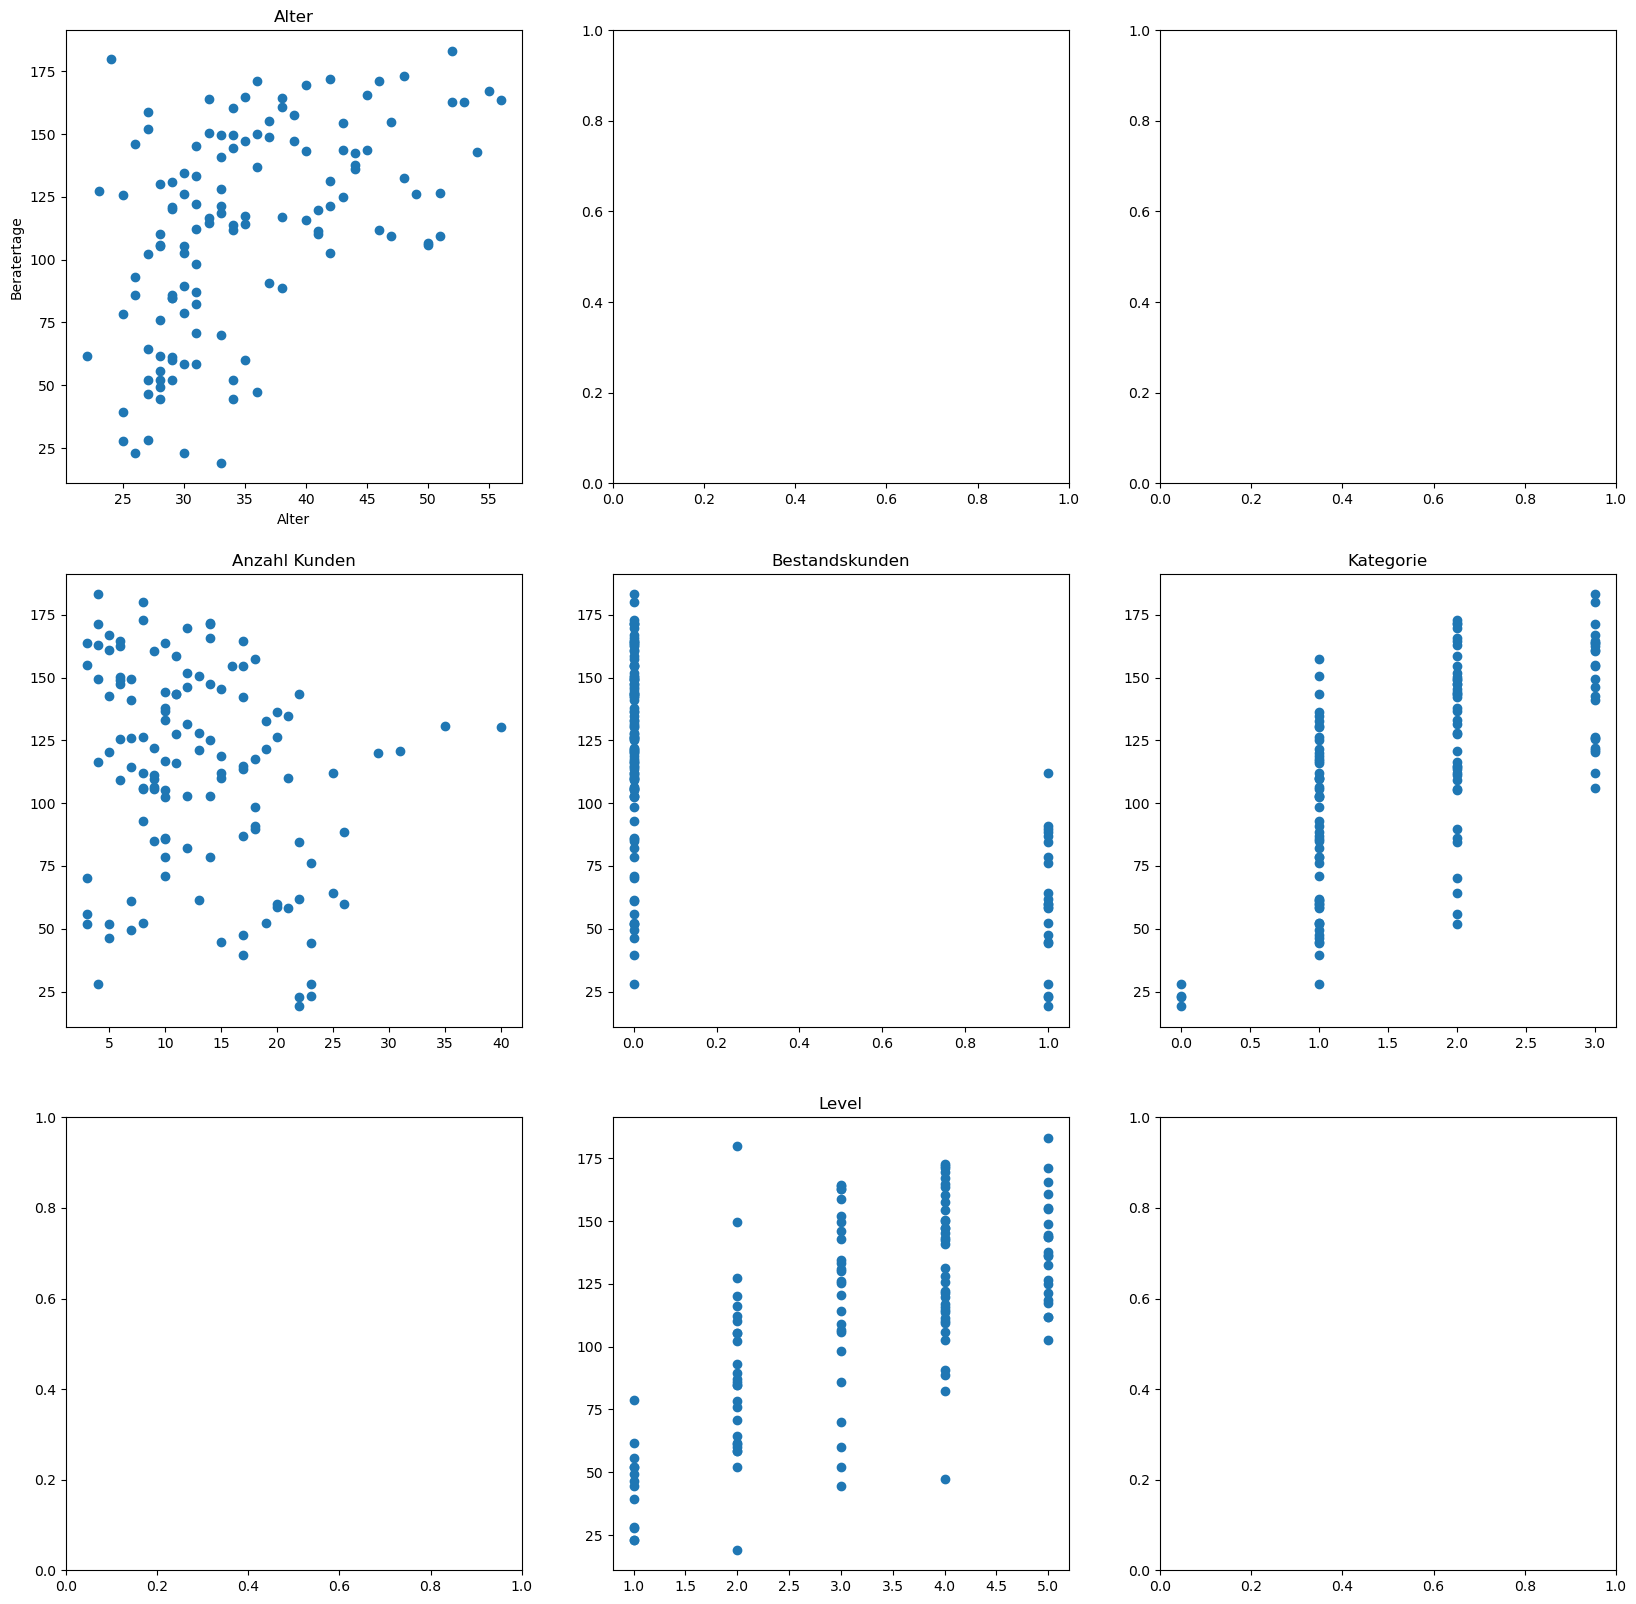

In [427]:
# show the correlation of the input features with the target variable in a scatter plot
fig, axs = plt.subplots(3, 3, figsize=(20, 20))
axs[0, 0].scatter(X['Alter'], y)
axs[0, 0].set_title('Alter')
axs[0, 0].set_xlabel('Alter')
axs[0, 0].set_ylabel('Beratertage')
#axs[0, 1].scatter(X['Berufserfahrung'], y)
#axs[0, 1].set_title('Berufserfahrung')
#axs[0, 2].scatter(X['Workdays'], y)
#axs[0, 2].set_title('Workdays')
axs[1, 0].scatter(X['Anzahl Kunden'], y)
axs[1, 0].set_title('Anzahl Kunden')
axs[1, 1].scatter(X['Bestandskunden'], y)
axs[1, 1].set_title('Bestandskunden')
axs[1, 2].scatter(X['Kategorie'], y)
axs[1, 2].set_title('Kategorie')
#axs[2, 0].scatter(X['FIS Umsatz pro Mitarbeiter'], y)
#axs[2, 0].set_title('FIS Umsatz pro Mitarbeiter')
axs[2, 1].scatter(X['Level'], y)
axs[2, 1].set_title('Level')

plt.show()

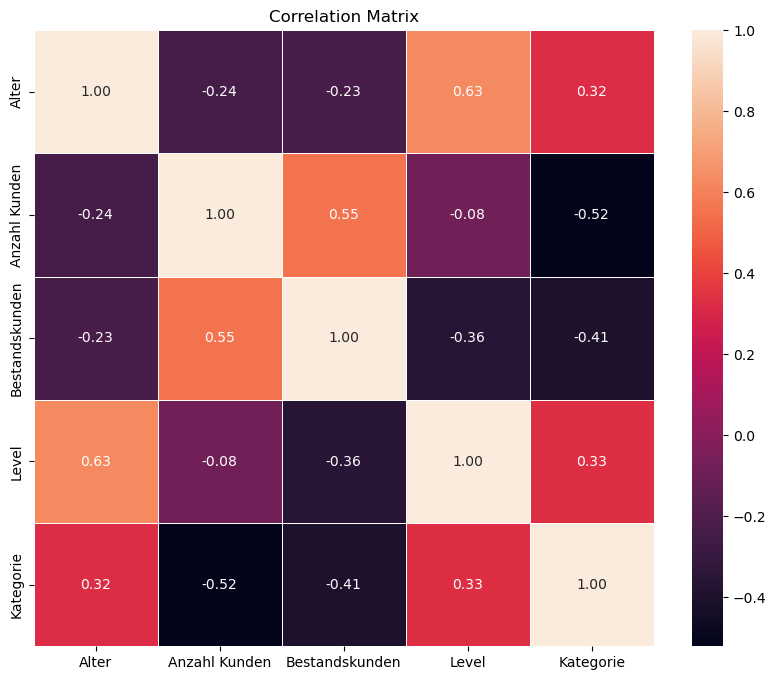

In [428]:
import seaborn as sns

correlation_matrix = X_train.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)

# Add title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

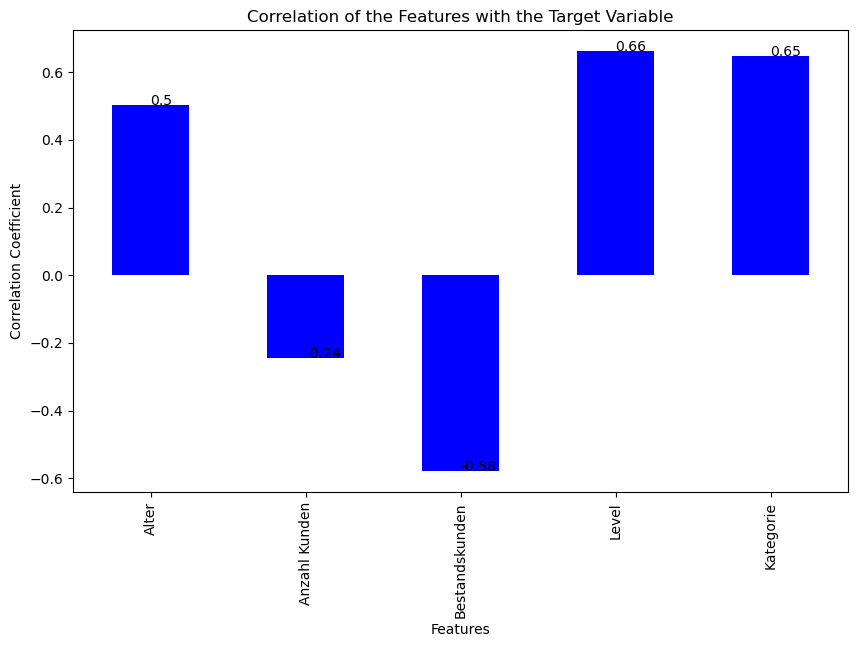

In [429]:
# Calculate correlation of each independent variable in X with the target variable y
correlation = X.corrwith(y)

# create a bar plot of the correlation of each independent variable with the target variable
plt.figure(figsize=(10, 6))
correlation.plot(kind='bar', color='blue')
# plot the values of each bar on the bar plot
for index, value in enumerate(correlation):
    plt.text(index, value, str(round(value, 2)))
plt.title('Correlation of the Features with the Target Variable')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient')
plt.show()

In [430]:
# create a pearson correlation test
from scipy.stats import pearsonr

# calculate the pearson correlation coefficient and the p-value for the correlation for every feature within X
for column in X:
    corr, p = pearsonr(X[column], y)
    print(f'Pearsons correlation coefficient between {column} and y: {corr}')
    print(f'p-value: {p}')
    if p > 0.05:
        print('The correlation is not significant')
    else:
        print('The correlation is significant')
    print('.......................................................')

Pearsons correlation coefficient between Alter and y: 0.5044992094813084
p-value: 1.9880609496311334e-09
The correlation is significant
.......................................................
Pearsons correlation coefficient between Anzahl Kunden and y: -0.244388896075226
p-value: 0.006020198305195097
The correlation is significant
.......................................................
Pearsons correlation coefficient between Bestandskunden and y: -0.57949295664304
p-value: 1.4365736618721084e-12
The correlation is significant
.......................................................
Pearsons correlation coefficient between Level and y: 0.6620474657622447
p-value: 4.2176117530974073e-17
The correlation is significant
.......................................................
Pearsons correlation coefficient between Kategorie and y: 0.64892270887354
p-value: 2.7500773723563656e-16
The correlation is significant
.......................................................


Nachdem das Model mit Hilfe von Linearer Regression erstellt wurde, wird nun ein Model mit Hilfe eines neuronalen Netzes erstellt.

In [431]:
import tensorflow as tf
#from sklearn.preprocessing import StandardScaler
import keras
from keras import layers

#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Split the data into training and cross validation data - 80% training, 20% cross validation
X_train_nn, X_cv_nn, y_train_nn, y_cv_nn = train_test_split(X, y, test_size=0.2, random_state=42)

print(
    f"Using {len(X_train_nn)} records for training "
    f"and {len(X_cv_nn)} records for cross validation")
# print all data types of X_train_nn
print(X_train_nn.dtypes)

Using 100 records for training and 25 records for cross validation
Alter             float64
Anzahl Kunden       int64
Bestandskunden    float64
Level             float64
Kategorie           int64
dtype: object


In [445]:
# build the neural network model
nn_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1)
])

# compile the model
nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# train the model
# stop training when the validation loss metric has stopped decreasing for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)

nn_model.fit(X_train_nn, y_train_nn, epochs=120, batch_size=1, validation_data=(X_cv_nn, y_cv_nn))


Epoch 1/120
100/100 [==============================] - 0s 769us/step - loss: 13218.8125 - mean_absolute_error: 107.3611 - val_loss: 10187.2969 - val_mean_absolute_error: 93.2262
Epoch 2/120
100/100 [==============================] - 0s 386us/step - loss: 9633.0723 - mean_absolute_error: 89.4307 - val_loss: 5546.6152 - val_mean_absolute_error: 65.9489
Epoch 3/120
100/100 [==============================] - 0s 398us/step - loss: 4440.7939 - mean_absolute_error: 57.9156 - val_loss: 1734.5824 - val_mean_absolute_error: 33.0842
Epoch 4/120
100/100 [==============================] - 0s 400us/step - loss: 1849.1511 - mean_absolute_error: 35.4218 - val_loss: 1065.1300 - val_mean_absolute_error: 26.2045
Epoch 5/120
100/100 [==============================] - 0s 377us/step - loss: 1516.1718 - mean_absolute_error: 31.7300 - val_loss: 1027.8512 - val_mean_absolute_error: 26.1158
Epoch 6/120
100/100 [==============================] - 0s 377us/step - loss: 1484.2720 - mean_absolute_error: 31.3317 - va

In [433]:
# evaluate the model with the cross validation data
print("Results for the cross validation data:")
print(nn_model.evaluate(X_cv_nn, y_cv_nn))

# evaluate the model with the training data
print("Results for the training data:")
print(nn_model.evaluate(X_train_nn, y_train_nn))

print(".......................................................")
print("Results from the linear regression model:")
print(f'Mean Squared Error CV: {mse_cv}')
print(f'Mean Absolute Error CV: {mae_cv}')
print(f'Root Mean Squared Error CV: {rmse_cv}')
print(f'Mean Squared Error Train: {mse_train}')
print(f'Mean Absolute Error Train: {mae_train}')
print(f'Root Mean Squared Error Train: {rmse_train}')

Results for the cross validation data:
1/1 [==============================] - 0s 34ms/step - loss: 639.3521 - mean_absolute_error: 21.4051
[639.35205078125, 21.40509033203125]
Results for the training data:
4/4 [==============================] - 0s 683us/step - loss: 459.9393 - mean_absolute_error: 16.9106
[459.93927001953125, 16.910587310791016]
.......................................................
Results from the linear regression model:
Mean Squared Error CV: 579.5804576668726
Mean Absolute Error CV: 18.909274946502745
Root Mean Squared Error CV: 24.074477308279665
Mean Squared Error Train: 486.8721909041801
Mean Absolute Error Train: 17.11958742725777
Root Mean Squared Error Train: 22.065180509213608


In [434]:
# save the tensorflow model to disk
nn_model.save('tf_bt_model.keras')